In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_ind
import matplotlib.gridspec as gridspec
import mne

In [2]:
behav_df = pd.read_csv('C:/Users/qmoreau/Documents/Work/Beta_bursts/Behavioral/behav_df_cleaned_new.csv')
burst_df = pd.read_csv('C:/Users/qmoreau/Documents/Work/Beta_bursts/Bursts/burst_features.csv')

In [3]:
burst_df.columns

Index(['subject', 'epoch', 'peak_time', 'peak_freq', 'peak_amp_base',
       'fwhm_freq', 'fwhm_time', 'trial', 'pp_ix', 'block', 'PC_1', 'PC_2',
       'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10',
       'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18',
       'PC_19', 'PC_20'],
      dtype='object')

In [4]:
lookup_df = behav_df[["coh_cat", "perturb_cat", "trial", "block", "subject"]]

# Merge the two DataFrames based on the specified columns and fill missing values with NaN
df_burst_behav = burst_df.merge(lookup_df, on=["trial", "block", "subject"], how='left')

In [5]:
# Define the time range
time_bin = 0.05  # in seconds
time_buffer = 0.125  # in seconds
time_range = np.arange(-1 - time_buffer, 2 + time_buffer, time_bin)  # in seconds
time_range_vis = time_range[12:54]
time_range_mot = time_range[12:46]

In [6]:

def calculate_burst_rates(behav_df, df_burst_behav, epoch, group, time_bin=0.05, time_buffer=0.125):
    """
    Calculate burst rates for a given epoch, group, and time range.

    Parameters:
    - behav_df: DataFrame containing behavioral data
    - df_burst_behav: DataFrame containing burst behavioral data
    - epoch: The epoch for which burst rates are calculated
    - group: The group for which burst rates are calculated
    - time_bin: Time bin for burst rate calculation
    - time_buffer: Time buffer for extending the time range

    Returns:
    - burst_rates_dict: Dictionary containing burst rates for each subject, block, and coh_cat combination
    """
# Select subjects based on the group
    group_subjects = behav_df[behav_df['group'] == group]['subject'].unique()

    # Define the time range
    time_range = np.arange(-1 - time_buffer, 2 + time_buffer, time_bin)

    burst_df = df_burst_behav[df_burst_behav['epoch'] == epoch]

    # Create a dictionary to store burst rates for each subject, block, and coh_cat combination
    burst_rates_dict = {}

    for subject in group_subjects:
        # Initialize an array for burst rates for the current subject
        subject_burst_rates = np.zeros((len(time_range),))

        subject_df = burst_df[burst_df['subject'] == subject]

        # Group by block and coh_cat
        grouped_df = subject_df.groupby(['block', 'coh_cat'])

        for (block, coh_cat), group in grouped_df:
            # Calculate burst rates for the current subject
            for i, t in enumerate(time_range):
                subject_burst_rates[i] = len(group[(group['peak_time'] >= t) & (group['peak_time'] < t + time_bin)]) / time_bin

            subject_burst_rates_smoothed = gaussian_filter1d(subject_burst_rates, sigma=1)

            # baseline correction
            subject_burst_rates_smoothed = ((subject_burst_rates_smoothed - np.mean(subject_burst_rates_smoothed[12:19])) / np.mean(subject_burst_rates_smoothed[12:19])) * 100

            # Store the burst rates in the dictionary with subject, block, and coh_cat as keys
            key = (block, coh_cat)
            if key not in burst_rates_dict:
                burst_rates_dict[key] = []

            burst_rates_dict[key].append(subject_burst_rates_smoothed)


    # Convert the lists of arrays into a single NumPy array for each key
    for key in burst_rates_dict:
        burst_rates_dict[key] = np.array(burst_rates_dict[key])

    return burst_rates_dict

In [7]:
implicit_burst_rates_mot = calculate_burst_rates(behav_df, df_burst_behav, 'mot', group="Implicit")
explicit_burst_rates_mot = calculate_burst_rates(behav_df, df_burst_behav, 'mot', group="Explicit")

In [8]:
implicit_baseline_mot = implicit_burst_rates_mot[(0, "zero")]
implicit_washout_mot = implicit_burst_rates_mot[(7, "zero")]

cohcats = ["zero", "low", "med", "high"]
implicit_tasks = {}

for coh in cohcats:
    implicit_tasks[coh] = np.mean([implicit_burst_rates_mot[(i, coh)] for i in range(1, 6)], axis=0)

implicit_task_mot = np.mean(list(implicit_tasks.values()), axis=0)


In [9]:
explicit_baseline_mot = explicit_burst_rates_mot[(0, "zero")]
explicit_washout_mot = explicit_burst_rates_mot[(7, "zero")]

cohcats = ["zero", "low", "med", "high"]
explicit_tasks = {}

for coh in cohcats:
    explicit_tasks[coh] = np.mean([explicit_burst_rates_mot[(i, coh)] for i in range(1, 6)], axis=0)

explicit_task_mot = np.mean(list(explicit_tasks.values()), axis=0)

In [10]:
def plot_and_cluster_data_blocktype(ax, time_range, data, colors, title, xlabel, ylabel):
    for i, (name, d) in enumerate(zip(['Implicit', 'Explicit'], data)):
        ax.plot(time_range, np.mean(d, axis=0), label=name, color=colors[i], linewidth=3)
        ax.fill_between(time_range, np.mean(d, axis=0) - np.std(d, axis=0) / np.sqrt(d.shape[0]), np.mean(d, axis=0) + np.std(d, axis=0) / np.sqrt(d.shape[0]), alpha=0.2, color=colors[i])

    tfce = dict(start=0, step=0.05)
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)

    print(clusters)

    sig_masks = [clusters[i] for i in range(len(cluster_p_values)) if cluster_p_values[i] < 0.05]
    if len(sig_masks) > 0:
        print(f"Significant clusters found!")
        print(cluster_p_values)
        concatenated_sig_mask = np.concatenate([np.ravel(mask) for mask, in sig_masks])
        val_p = np.full(len(time_range), 3)
        ax.scatter(time_range[concatenated_sig_mask], val_p[concatenated_sig_mask], color='pink', s=15)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, labelpad=10)
    ax.set_title(title)
    ax.legend(loc='lower left')

def plot_and_cluster_data(ax, time_range, data, colors, title, xlabel, ylabel):
    for i, (name, d) in enumerate(zip(['Baseline', 'Washout', 'Adaptation'], data)):
        ax.plot(time_range, np.mean(d, axis=0), label=name, color=colors[i], linewidth=3)
        ax.fill_between(time_range, np.mean(d, axis=0) - np.std(d, axis=0) / np.sqrt(d.shape[0]), np.mean(d, axis=0) + np.std(d, axis=0) / np.sqrt(d.shape[0]), alpha=0.2, color=colors[i])

    tfce = dict(start=0, step=0.05)
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)

    print(clusters)

    sig_masks = [clusters[i] for i in range(len(cluster_p_values)) if cluster_p_values[i] < 0.05]
    if len(sig_masks) > 0:
        print(f"Significant clusters found!")
        print(cluster_p_values)
        concatenated_sig_mask = np.concatenate([np.ravel(mask) for mask, in sig_masks])
        val_p = np.full(len(time_range), 3)
        ax.scatter(time_range[concatenated_sig_mask], val_p[concatenated_sig_mask], color='pink', s=25)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, labelpad=10)
    ax.set_title(title)
    ax.legend(loc='lower left')

def plot_and_cluster_data_coh(ax, time_range, data, colors, title, xlabel, ylabel):
    for i, (name, d) in enumerate(zip(['Zero', 'Low', 'Med', 'High'], data)):
        ax.plot(time_range, np.mean(d, axis=0), label=name, color=colors[i], linewidth=3)
        ax.fill_between(time_range, np.mean(d, axis=0) - np.std(d, axis=0) / np.sqrt(d.shape[0]), np.mean(d, axis=0) + np.std(d, axis=0) / np.sqrt(d.shape[0]), alpha=0.2, color=colors[i])

    tfce = dict(start=0, step=0.05)
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)

    print(clusters)

    sig_masks = [clusters[i] for i in range(len(cluster_p_values)) if cluster_p_values[i] < 0.05]
    if len(sig_masks) > 0:
        print(f"Significant clusters found!")
        concatenated_sig_mask = np.concatenate([np.ravel(mask) for mask, in sig_masks])
        val_p = np.full(len(time_range), 3)
        ax.scatter(time_range[concatenated_sig_mask], val_p[concatenated_sig_mask], color='pink', s=25)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='lower left')

In [11]:


cohcats = ["zero", "low", "med", "high"]

implicit_task_mot_zero = {}
implicit_task_mot_low = {}
implicit_task_mot_med = {}
implicit_task_mot_high = {}

for coh in cohcats:
    if coh == "zero":
        implicit_task_mot_zero = np.mean([implicit_burst_rates_mot[(i, coh)] for i in range(1, 6)], axis=0)
    elif coh == "low":
        implicit_task_mot_low = np.mean([implicit_burst_rates_mot[(i, coh)] for i in range(1, 6)], axis=0)
    elif coh == "med":
        implicit_task_mot_med = np.mean([implicit_burst_rates_mot[(i, coh)] for i in range(1, 6)], axis=0)
    elif coh == "high":
        implicit_task_mot_high = np.mean([implicit_burst_rates_mot[(i, coh)] for i in range(1, 6)], axis=0)

explicit_task_mot_zero = {}
explicit_task_mot_low = {}
explicit_task_mot_med = {}
explicit_task_mot_high = {}

for coh in cohcats:
    if coh == "zero":
        explicit_task_mot_zero = np.mean([explicit_burst_rates_mot[(i, coh)] for i in range(1, 6)], axis=0)
    elif coh == "low":
        explicit_task_mot_low = np.mean([explicit_burst_rates_mot[(i, coh)] for i in range(1, 6)], axis=0)
    elif coh == "med":
        explicit_task_mot_med = np.mean([explicit_burst_rates_mot[(i, coh)] for i in range(1, 6)], axis=0)
    elif coh == "high":
        explicit_task_mot_high = np.mean([explicit_burst_rates_mot[(i, coh)] for i in range(1, 6)], axis=0)
        




Using a threshold of 4.121338
stat_fun(H1): min=0.000110 max=1.800880
Running initial clustering …
Found 0 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)


[]
Using a threshold of 4.121338
stat_fun(H1): min=0.000134 max=4.813862
Running initial clustering …
Found 1 cluster


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:7: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

[(array([5]),)]
Using a threshold of 4.121338
stat_fun(H1): min=0.004095 max=2.328988
Running initial clustering …
Found 0 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:7: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)


[]
Using a threshold of 3.168246


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:30: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)


stat_fun(H1): min=0.081656 max=3.568048
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

[(array([13, 14]),)]
Using a threshold of 3.178799
stat_fun(H1): min=0.213682 max=3.641011
Running initial clustering …
Found 2 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:30: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

[(array([12]),), (array([16, 17]),)]
Using a threshold of 2.731807
stat_fun(H1): min=0.030920 max=1.066629
Running initial clustering …
Found 0 clusters
[]
Using a threshold of 2.739502
stat_fun(H1): min=0.067557 max=0.903714
Running initial clustering …
Found 0 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:53: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:53: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:53: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data, n_permutations=1000)#, threshold=tfce)
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_21876\265542922.py:53: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutat

[]


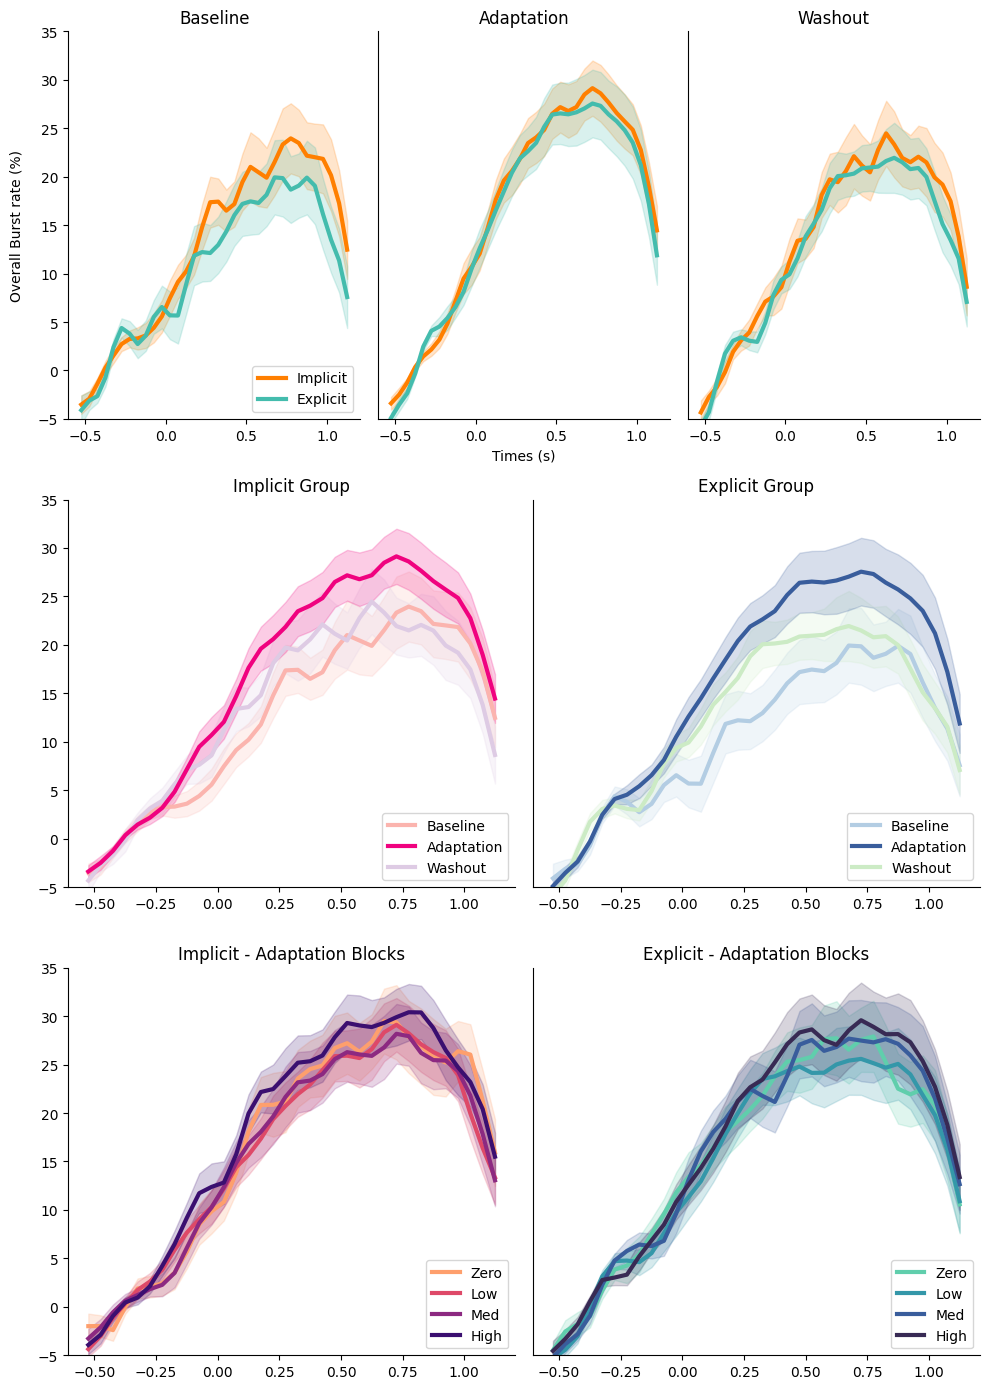

In [12]:
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(3, 6)  # Change to 4 columns
colors0 = sns.color_palette("magma", n_colors=6)
colors1 = sns.color_palette("mako_r", n_colors=10)
pastel = sns.color_palette("Pastel1", n_colors=6)
adapt1 = sns.color_palette("Set1", n_colors=9)
adapt2 = sns.color_palette("Accent", n_colors=8)
colors4 = sns.color_palette("magma_r", n_colors=4)
colors5 = sns.color_palette("mako_r", n_colors=4)

colors2 = [pastel[0], pastel[3], adapt2[5],]
colors3 = [pastel[1], pastel[2], colors5[2]]

colorbl = [adapt1[4], colors1[2]]


ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
# Implicit vs Explicit Group Visual Baseline
plot_and_cluster_data_blocktype(ax1, time_range[12:46], [implicit_baseline_mot[:, 12:46], explicit_baseline_mot[:, 12:46]], colorbl, "Baseline", "", "Overall Burst rate (%)")
ax1.set_ylim(-5, 35)
ax1.legend(loc='lower right')
# remove right and top lines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Implicit vs Explicit Group Visual Adaptation
plot_and_cluster_data_blocktype(ax2, time_range[12:46], [implicit_task_mot[:, 12:46], explicit_task_mot[:, 12:46]], colorbl, "Adaptation", "", "")
ax2.set_ylim(-5, 35)
ax2.set_yticks([])
ax2.set_xlabel("Times (s)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.get_legend().remove()


# Implicit vs Explicit Group Visual Baseline
plot_and_cluster_data_blocktype(ax3, time_range[12:46], [implicit_washout_mot[:, 12:46], explicit_washout_mot[:, 12:46]], colorbl, "Washout", "", "")
ax3.set_ylim(-5, 35)
ax3.set_yticks([])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.get_legend().remove()


# Create subplots that span equal columns
ax4 = fig.add_subplot(gs[1, :3])  # This spans 2 columns
ax5 = fig.add_subplot(gs[1, 3:])  # This spans the remaining 2 columns

# Implicit Group Visual
plot_and_cluster_data(ax4, time_range[12:46], [implicit_baseline_mot[:, 12:46], implicit_washout_mot[:, 12:46], implicit_task_mot[:, 12:46]], colors2, "Implicit Group", "", "")
# reorder legend so that it is Baseline, Adaptation, Washout
handles, labels = ax4.get_legend_handles_labels()
labels = [labels[0], labels[2], labels[1]]
handles = [handles[0], handles[2], handles[1]]
ax4.legend(handles, labels, loc='lower right')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.set_ylim(-5, 35)

# Explicit Group Visual
plot_and_cluster_data(ax5, time_range[12:46], [explicit_baseline_mot[:, 12:46], explicit_washout_mot[:, 12:46], explicit_task_mot[:, 12:46]], colors3, "Explicit Group", "", "")
# reorder legend so that it is Baseline, Adaptation, Washout
handles, labels = ax5.get_legend_handles_labels()
labels = [labels[0], labels[2], labels[1]]
handles = [handles[0], handles[2], handles[1]]
ax5.legend(handles, labels, loc='lower right')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.set_ylim(-5, 35)
ax5.set_yticks([])


ax6 = fig.add_subplot(gs[2, :3])  # This spans 2 columns
ax7 = fig.add_subplot(gs[2, 3:])  # This spans the remaining 2 columns

# Implicit Group Visual
plot_and_cluster_data_coh(ax6, time_range[12:46], [implicit_task_mot_zero[:, 12:46], implicit_task_mot_low[:, 12:46], implicit_task_mot_med[:, 12:46],  implicit_task_mot_high[:, 12:46]], colors4, "Implicit - Adaptation Blocks", "", "")
ax6.set_ylim(-5, 35)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.legend(loc='lower right')

# Explicit Group Visual
plot_and_cluster_data_coh(ax7, time_range[12:46], [explicit_task_mot_zero[:, 12:46], explicit_task_mot_low[:, 12:46], explicit_task_mot_med[:, 12:46],  explicit_task_mot_high[:, 12:46]], colors5, "Explicit - Adaptation Blocks", "", "")
ax7.set_ylim(-5, 35)
ax7.set_yticks([])
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.legend(loc='lower right')

plt.tight_layout()
plt.show()
